In [1]:
# Description: Plot Figure 5 (seasonal time-averaged bottom vortex stretching residual and surface stress curl)
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        April/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from xarray import open_dataset
import cartopy as ctpy
import cartopy.crs as crs
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from os.path import isfile
from matplotlib.ticker import FuncFormatter

In [3]:
def cbfmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if b==0:
        return r'$0$'
    else:
        return r'${}\times10^{{{}}}$'.format(a, b)


def near2(x, y, x0, y0, npts=1, return_index=False):
    """
    USAGE
    -----
    xnear, ynear = near2(x, y, x0, y0, npts=1, return_index=False)

    Finds 'npts' points (defaults to 1) in arrays 'x' and 'y'
    that are closest to a specified '(x0, y0)' point. If
    'return_index' is True (defauts to False), then the
    indices of the closest point(s) are returned.

    Example
    -------
    >>> x = np.arange(0., 100., 0.25)
    >>> y = np.arange(0., 100., 0.25)
    >>> x, y = np.meshgrid(x, y)
    >>> x0, y0 = 44.1, 30.9
    >>> xn, yn = near2(x, y, x0, y0, npts=1)
    >>> print("(x0, y0) = (%f, %f)"%(x0, y0))
    >>> print("(xn, yn) = (%f, %f)"%(xn, yn))
    """
    x, y = map(np.array, (x, y))
    shp = x.shape

    xynear = []
    xyidxs = []
    dx = x - x0
    dy = y - y0
    dr = dx**2 + dy**2
    for n in range(npts):
        xyidx = np.unravel_index(np.nanargmin(dr), dims=shp)
        if return_index:
            xyidxs.append(xyidx)
        xyn = (x[xyidx], y[xyidx])
        xynear.append(xyn)
        dr[xyidx] = np.nan

    if npts==1:
        xynear = xynear[0]
        if return_index:
            xyidxs = xyidxs[0]

    if return_index:
        return xyidxs
    else:
        return xynear


def bmap(ax, proj, bbox, draw_labels=True, land=None, segment='Ross'):
    ax.coastlines('10m', zorder=9999)
    if land is not None:
        ax.add_feature(land, zorder=999)
    gl = ax.gridlines(draw_labels=draw_labels, linewidth=0, crs=ccrs.PlateCarree())
    if draw_labels:
        gl.xlabels_top = gl.ylabels_left = True
        gl.xlabels_bottom = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

    return ax

In [4]:
plt.close('all')
head_data = '../../data_reproduce_figs/'
head = head_data

terms = ['curlvdiff', 'curlnonl', 'betav', 'stretchp', 'errcor', 'curlpgrad', 'curlhdiff', 'res']
terms_titles = dict(Icurlnonl=r"-NONL$_\xi$", Ibetav=r"$-\beta V$", Istretchp="$-fw_I$", Ierrcor=r"ERRCOR", Icurlpgrad=r"PGRD$_\xi$", Icurlhdiff=r"HVIS$_\xi$", Icurlvdiff=r"VVIS$_\xi$", Ires=r"RES$_\xi$")
termsi = np.array(['I'+term for term in terms])
terms = termsi

fnames = ['vortbdgt_2005-2009JFMavgzint.nc',
          'vortbdgt_2005-2009AMJavgzint.nc',
          'vortbdgt_2005-2009JASavgzint.nc',
          'vortbdgt_2005-2009ONDavgzint.nc']

# Get segment lat/lon limits.
segs_lims = {
'Amundsen-Bellingshausen':[-130., -75., -75., -68.],
}
segment = 'Amundsen-Bellingshausen'
fileij = head_data + 'ijisobaths.npz'

#=======================================

nc = Dataset(head_data + 'POP-dzu_dzt_kzit_subsetSO.nc')
lont, latt = nc['TLONG'][:], nc['TLAT'][:]

# Get isobath indices.
fisobs = head_data + 'isobaths.nc'
ncx = Dataset(fisobs)
iisob, misob, oisob = 800, 1000, 2500
xi = ncx["%d m isobath (T-points)"%iisob]['xiso'][:]
yi = ncx["%d m isobath (T-points)"%iisob]['yiso'][:]
di = ncx["%d m isobath (T-points)"%iisob]['diso'][:]
xm = ncx["%d m isobath (T-points)"%misob]['xiso'][:]
ym = ncx["%d m isobath (T-points)"%misob]['yiso'][:]
dm = ncx["%d m isobath (T-points)"%misob]['diso'][:]
xo = ncx["%d m isobath (T-points)"%oisob]['xiso'][:]
yo = ncx["%d m isobath (T-points)"%oisob]['yiso'][:]
do = ncx["%d m isobath (T-points)"%oisob]['diso'][:]

fmt = 'png'
kwsavefig = dict(fmt=fmt, bbox_inches='tight', pad_inches=0.1)
lightgray = [.85]*3
darkgray = [.35]*3

if isfile(fileij):
    d = np.load(fileij)
    dijs = ['ii', 'ji', 'im', 'jm', 'io', 'jo']
    for dij in dijs:
        vars().update({dij:d[dij]})
else:
    Ii, Ji, Im, Jm, Io, Jo = [], [], [], [], [], []
    for xx, yy in zip(xi, yi):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Ii.append(xa); Ji.append(ya)
    for xx, yy in zip(xm, ym):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Im.append(xa); Jm.append(ya)
    for xx, yy in zip(xo, yo):
        xa, ya = near2(lont, latt, xx, yy, return_index=True)
        Io.append(xa); Jo.append(ya)
    d = dict(ii=Ii, ji=Ji, im=Im, jm=Jm, io=Io, jo=Jo)
    np.savez(fileij, **d)

fuv = head_data+'uvIT2005-2009.nc'
dsuv = Dataset(fuv)
IorT = 'I'

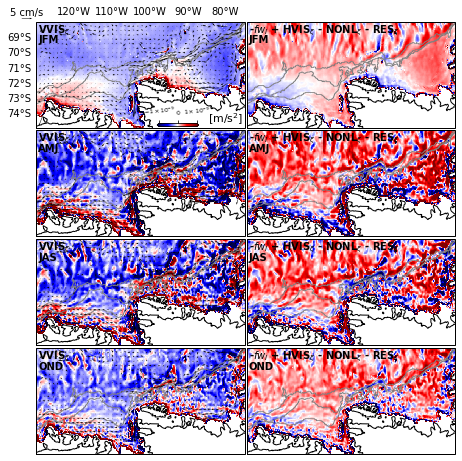

In [5]:
# Plot.
proj = ccrs.PlateCarree(central_longitude=0)

fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(7.5, 10), subplot_kw=dict(projection=proj))
bbox = segs_lims[segment]


#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[0]
ssn = 'JFM'
ds = open_dataset(head+fname)

ax = axs[0][0]
Term = np.ma.masked_invalid(ds['Icurlvdiff'])
Term[:,0] = Term[:,1]

vvma = 1e-9
vvmi = -vvma

draw_labels = True

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

lonu, latu = dsuv['lon'][:], dsuv['lat'][:]
fblon = np.logical_and(lonu>=bbox[0], lonu<=bbox[1])
fblat = np.logical_and(latu>=bbox[2], latu<=bbox[3])
fbbox = np.logical_and(fblon, fblat)
lonu = lonu[fbbox]
latu = latu[fbbox]
Uu, Vv = dsuv[IorT+'u_'+ssn][:][fbbox], dsuv[IorT+'v_'+ssn][:][fbbox]
q = ax.quiver(lonu, latu, Uu, Vv, regrid_shape=(50, 25), scale=100, zorder=999, transform=ccrs.PlateCarree()) # Bottleneck.
xq, yq = -0.045, 1.03
qksc = 5 # [cm/s]
ax.quiverkey(q, xq, yq, qksc, "%d cm/s"%qksc, coordinates="axes", labelpos="N", labelsep=0.02)

xt, yt = 0.01, 0.9
ax.text(xt, yt, terms_titles['Icurlvdiff'], fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)

caxx, caxy = 0.58, 0.01
cbaxes = ax.inset_axes([caxx, caxy, 0.20, 0.03])

cb = fig.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal', extend='both', format=FuncFormatter(cbfmt))
cb.set_ticks([vvmi, 0, vvma])
cb.ax.xaxis.set_tick_params(labelsize=6, rotation=5)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

xt, yt = 0.825, 0.05
ax.text(xt, yt, r'[m/s$^2$]', fontsize=11, transform=ax.transAxes)








#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[1]
ssn = 'AMJ'
ds = open_dataset(head+fname)

ax = axs[1][0]
Term = np.ma.masked_invalid(ds['Icurlvdiff'])
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

lonu, latu = dsuv['lon'][:], dsuv['lat'][:]
fblon = np.logical_and(lonu>=bbox[0], lonu<=bbox[1])
fblat = np.logical_and(latu>=bbox[2], latu<=bbox[3])
fbbox = np.logical_and(fblon, fblat)
lonu = lonu[fbbox]
latu = latu[fbbox]
Uu, Vv = dsuv[IorT+'u_'+ssn][:][fbbox], dsuv[IorT+'v_'+ssn][:][fbbox]
q = ax.quiver(lonu, latu, Uu, Vv, regrid_shape=(50, 25), scale=100, zorder=999, transform=ccrs.PlateCarree()) # Bottleneck.

xt, yt = 0.01, 0.9
ax.text(xt, yt, terms_titles['Icurlvdiff'], fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)







#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[2]
ssn = 'JAS'
ds = open_dataset(head+fname)

ax = axs[2][0]
Term = np.ma.masked_invalid(ds['Icurlvdiff'])
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

lonu, latu = dsuv['lon'][:], dsuv['lat'][:]
fblon = np.logical_and(lonu>=bbox[0], lonu<=bbox[1])
fblat = np.logical_and(latu>=bbox[2], latu<=bbox[3])
fbbox = np.logical_and(fblon, fblat)
lonu = lonu[fbbox]
latu = latu[fbbox]
Uu, Vv = dsuv[IorT+'u_'+ssn][:][fbbox], dsuv[IorT+'v_'+ssn][:][fbbox]
q = ax.quiver(lonu, latu, Uu, Vv, regrid_shape=(50, 25), scale=100, zorder=999, transform=ccrs.PlateCarree()) # Bottleneck.

xt, yt = 0.01, 0.9
ax.text(xt, yt, terms_titles['Icurlvdiff'], fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)









#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[3]
ssn = 'OND'
ds = open_dataset(head+fname)

ax = axs[3][0]
Term = np.ma.masked_invalid(ds['Icurlvdiff'])
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

lonu, latu = dsuv['lon'][:], dsuv['lat'][:]
fblon = np.logical_and(lonu>=bbox[0], lonu<=bbox[1])
fblat = np.logical_and(latu>=bbox[2], latu<=bbox[3])
fbbox = np.logical_and(fblon, fblat)
lonu = lonu[fbbox]
latu = latu[fbbox]
Uu, Vv = dsuv[IorT+'u_'+ssn][:][fbbox], dsuv[IorT+'v_'+ssn][:][fbbox]
q = ax.quiver(lonu, latu, Uu, Vv, regrid_shape=(50, 25), scale=100, zorder=999, transform=ccrs.PlateCarree()) # Bottleneck.

xt, yt = 0.01, 0.9
ax.text(xt, yt, terms_titles['Icurlvdiff'], fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)









#*******************************************
#********** vortex stretching residual *****
#*******************************************
txt_strechres = r"-$fw_I$ + HVIS$_\xi$ - NONL$_\xi$ - RES$_\xi$"



#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[0]
ssn = 'JFM'
ds = open_dataset(head+fname)

ax = axs[0][1]
Term = np.ma.masked_invalid(ds['Istretchp']+ds['Icurlhdiff']+ds['Icurlnonl']-ds['Ires']) # Ires goes to the RHS.
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

xt, yt = 0.01, 0.9
ax.text(xt, yt, txt_strechres, fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)









#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[1]
ssn = 'AMJ'
ds = open_dataset(head+fname)

ax = axs[1][1]
Term = np.ma.masked_invalid(ds['Istretchp']+ds['Icurlhdiff']+ds['Icurlnonl']-ds['Ires']) # Ires goes to the RHS.
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

xt, yt = 0.01, 0.9
ax.text(xt, yt, txt_strechres, fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)








#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[2]
ssn = 'JAS'
ds = open_dataset(head+fname)

ax = axs[2][1]
Term = np.ma.masked_invalid(ds['Istretchp']+ds['Icurlhdiff']+ds['Icurlnonl']-ds['Ires']) # Ires goes to the RHS.
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

xt, yt = 0.01, 0.9
ax.text(xt, yt, txt_strechres, fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)








#--------------------------------------------
#--------------------------------------------
#--------------------------------------------
fname = fnames[3]
ssn = 'OND'
ds = open_dataset(head+fname)

ax = axs[3][1]
Term = np.ma.masked_invalid(ds['Istretchp']+ds['Icurlhdiff']+ds['Icurlnonl']-ds['Ires']) # Ires goes to the RHS.
Term[:,0] = Term[:,1]

draw_labels = False

ax = bmap(ax, proj, bbox, segment=segment, draw_labels=draw_labels, land=None)
ax.set_extent(bbox, crs=proj)
ax.set_aspect(4)

cs = ax.pcolormesh(lont, latt, Term, vmin=vvmi, vmax=vvma, cmap=plt.cm.seismic, zorder=2, transform=ccrs.PlateCarree())

fi = ~np.logical_or(xi<=-179.9, xi>179.9)
fm = ~np.logical_or(xm<=-179.9, xm>179.9)
fo = ~np.logical_or(xo<=-179.9, xo>179.9)
ax.plot(xi[fi], yi[fi], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xm[fm], ym[fm], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())
ax.plot(xo[fo], yo[fo], 'gray', linewidth=0.8, transform=ccrs.PlateCarree())

xt, yt = 0.01, 0.9
ax.text(xt, yt, txt_strechres, fontsize=10, fontweight='black', transform=ax.transAxes)
ax.text(xt, yt-0.1, ssn, fontsize=10, fontweight='black', transform=ax.transAxes)










fig.subplots_adjust(hspace=-0.5, wspace=0.01)
plt.show()
fig.savefig("fig05.png", **kwsavefig)